<a href="https://colab.research.google.com/github/kiyong21c/nadocoding/blob/master/20220523_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망
 - 합성곱 신경망 필터는 이미지의 특징을 찾는다
 - 처음에는 기본적 특징(직선, 곡선) → 층이 깊어질수록 다양하고 구체적인 특징 감지
 - 어떤 특징이 이미지의 어느 위치에 놓이더라도 쉽게 감지 할 수 있도록 너비, 높이 차원을 줄여나간다

## 풀링
풀링 사용이유

 - 합성곱에서 스트라이드를 크게하여 특성맵을 줄이는것보다
 - 풀링층에서 크기를 줄이는 것이 경험적으로 나은 성능을 냄


풀링의 특징
 
 - 가중치가 없다
 - 패딩이 없다
 - 특성 맵의 개수는 변하지 않고 그대로 : (4,4,3) → (2,2,3)
 - 풀링크기(2,2)와 스트라이드(가로세로 2칸씩)가 같다
 - 매개변수 2가지(대부분 기본값 사용) : strides=2, padding='valid'

 keras.layers.Maxpooling2D(2, strides=2, padding='valid')

## 컬러 이미지를 사용한 합성곱
 - 컬러이미지는 너비, 높이 차원 외에 깊이 차원(또는 채널 차원)이 있음
 - 필터의(=커널) 배열의 깊이는 항상 입력의 깊이와 같다
 - **케라스의 합성곱 층은 항상 깊이(채널) 차원 입력을 기대한다.**
 - 즉, **흑백이미지일 경우 깊이 차원이 1인 3차원 배열로 변환하여 전달**

In [1]:
# 흑백이미지는 2차원 배열 이지만 Conv2D 층을 사용하기 위해 마지막엥 채널 차원을 추가
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
# (60,000, 28, 28) → (60,000, 28, 28, 1)
train_scaled = train_input.reshape(-1,28,28,1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)


4431872/4422102 [==============================] - 0s 0us/step


In [2]:
train_input.shape

(60000, 28, 28)

In [3]:
train_scaled.shape

(48000, 28, 28, 1)

# 합성곱 신경망 만들기

In [2]:
model = keras.Sequential() # 모델 생성(인스턴스)
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))
# 32개의 필터 사용, 커널의 크기 (3, 3), 렐루 활성화 함수, 세임 패딩, 입력 차원 지정
# → 특성맵의 크기 (28,28,32)

In [3]:
model.add(keras.layers.MaxPooling2D(2))
# 일반적인 풀링크기인 (2,2) 형태 : 가로세로 크기가 같으면 정수 하나로 지정
# → 특성맵의 크기 (14,14,32)

In [4]:
# 합성곱-풀링 층 추가
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
# → 특성맵의 크기 (7,7,64)

In [5]:
# 일렬로 펼치기(Flatten층) → 은닉층(Dense층) 추가 → 드롭아웃 → 출력층(Dense층)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))
# 패션MNIST 데이터셋은 클래스10개를 분류하는 다중분류 문제이므로 : 마지막 층의 활성화 함수는 softmax

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

모델 파라미터 개수 확인
 - 첫번째 합성곱 층 : 32개의 필터, 커널의크기(3,3), 깊이 1, 필터 마다 하나의 절편
 - 즉, 3 X 3 X 1 X 32 + 32 = 320개 파라미터


 - 두번째 합성곱 층 : 64개의 필터, 커널의 크기(3,3), 깊이 32, 필터 마다 하나의 절편
 - 즉, 3 X 3 X 32 X 64 + 64 = 18,496개의 파라미터


 - 은닉층 : (7,7,64) 크기의 특성맵을 1차원 배열로 펼친후 100개의 뉴런과 완전연결
 - 즉, 3136 X 100 + 100 = 313,700개의 파라미터


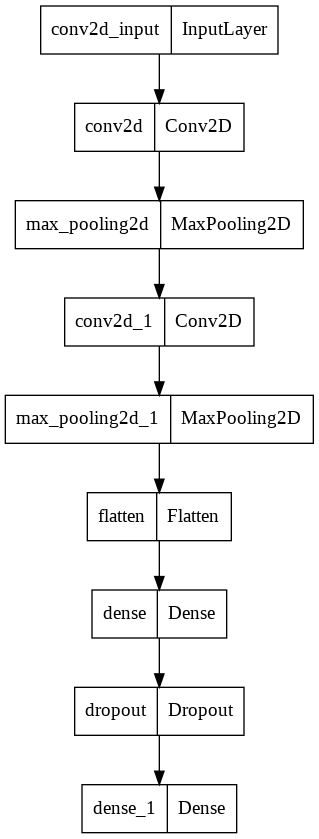

In [9]:
# keras.utils 패키지의 plot_model() 함수
keras.utils.plot_model(model) # summary() 메서드 외에 층의 구성을 그림으로 표현
# 상자 왼쪽:층 이름, 오른쪽:사용된 클래스

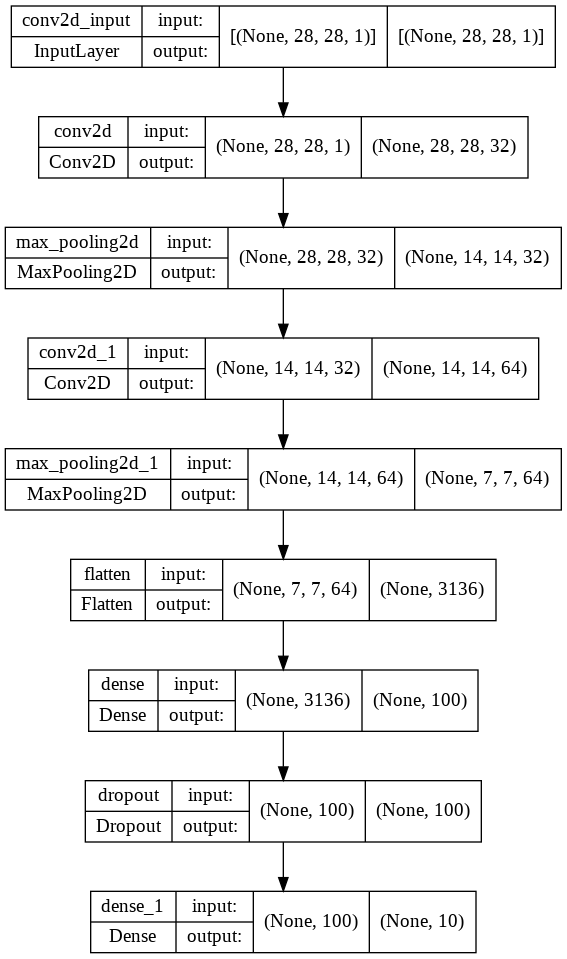

In [10]:
keras.utils.plot_model(model, show_shapes=True) # 입/출력 크기 표시

### 모델 컴파일, 훈련

In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 18s 4ms/step - loss: 0.5223 - accuracy: 0.8148 - val_loss: 0.3324 - val_accuracy: 0.8727
Epoch 2/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3433 - accuracy: 0.8782 - val_loss: 0.2765 - val_accuracy: 0.9008
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2935 - accuracy: 0.8938 - val_loss: 0.2451 - val_accuracy: 0.9111
Epoch 4/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2606 - accuracy: 0.9064 - val_loss: 0.2389 - val_accuracy: 0.9091
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2346 - accuracy: 0.9147 - val_loss: 0.2350 - val_accuracy: 0.9122
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2145 - accuracy: 0.9209 - val_loss: 0.2199 - val_accuracy: 0.9195
Epoch 7/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1980 - accuracy: 0.9266 - val_loss: 0.2186 - val_accuracy

 - Epoch가 20회 중 9번째에서 EarlyStop

 - 검증손실(val_loss)가 10번째 Epoch부터 2번연속 상승

 - EarlyStop은 9번째에서 되었지만, val_loss가 가장 낮은 7번째 Epoch의 파라미터로 현재 모델 객체가 복원 됨

 - 즉, ModelCheckpoint콜백이 저장한 best-cnn-model.h5 파일을 다시 읽을 필요가 없음

In [7]:
early_stopping_cb.stopped_epoch # 0부터 시작이라 8은 9번째 epoch를 의미

8

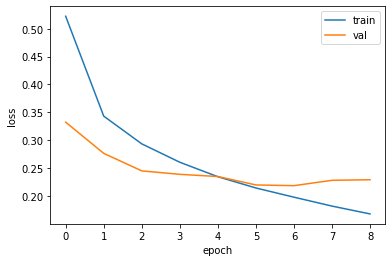

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [9]:
model.evaluate(val_scaled, val_target)
# 최상의 파라미터가 적용된 모델로서 평가됨
# fit() 메서드의 출력 중 7번째 에포크의 출력과 동일

375/375 [==============================] - 1s 3ms/step - loss: 0.2186 - accuracy: 0.9198


[0.21860426664352417, 0.9198333621025085]